In [1]:
import pandas as pd
import datetime
import argparse
from scipy import sparse
import scipy.io
from scipy.stats import zscore, rankdata
from sklearn.preprocessing import binarize
from sklearn import metrics
from itertools import cycle
import os
import pickle
import seaborn as sns
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import sys
import re
import math
import datetime
from scipy.spatial import distance
from scipy.cluster import hierarchy
import scanpy as sc
from itertools import combinations
from copy import deepcopy
import collections
import functools
import louvain
import leidenalg

In [2]:
print(sc.__version__)
top_dir = "../data/bam_p_cd4/"

1.10.3


## Data setup 1
* from bam files

## Data setup 2
* From text files
* ../data/geo_metadata/

In [4]:
geo_dir = "../data/geo_metadata/"
tail = ['', '_raw'][1]
matrix = scipy.io.mmread(os.path.join(geo_dir, "GSE273197_scrna_X"+tail+".mtx"))
matrix = sparse.csr_matrix(matrix, dtype=np.float32)
obs = pd.read_csv(os.path.join(geo_dir, "GSE273197_scrna_obs"+tail+".csv"), index_col=0)
var = pd.read_csv(os.path.join(geo_dir, "GSE273197_scrna_var"+tail+".csv"), index_col=0)
all_cells = sc.AnnData(matrix, obs=obs, var=var)
print(all_cells)
with open("scarmadillo_filtered_scobj.pyn", "wb") as f:
    pickle.dump(all_cells, f)

AnnData object with n_obs × n_vars = 16093 × 33472
    obs: 'barcode', 'batch', 'cov'
    var: 'symbol', 'cov'


In [5]:
def data_preprocess(adata, norm=True, spike_in=True):
    if spike_in:
        spike_in_label = [c for c in adata.var.index if 'Spikein' in c]
        adata.obs = adata.obs.assign(n_counts_spike= adata[:,spike_in_label].X.sum(axis=1))
        a = adata.obs.loc[:,'n_counts_spike']
        print(spike_in_label, a)
        print(np.mean(a), np.max(a), np.min(a))
        adata = adata[:,~adata.var.index.str.startswith('gSpikein')]
        adata.obs = adata.obs.assign(n_counts=adata.X.sum(axis=1)) 
        sns_plot = sns.scatterplot(data=adata.obs, x="n_counts", y="n_counts_spike")
        fig = sns_plot.get_figure()
        fig.savefig("total_spike_correlation.pdf")
    if norm:
        print(adata.shape)
        sc.pp.filter_genes(adata, min_counts=10)
        print(adata.shape)
        sc.pp.normalize_per_cell(adata)
    return adata

def data_postprocess(adata, n_top_genes=2000, output='pca_hvg.pdf'):
    adata.raw = adata
    sc.pp.log1p(adata) # compute log for highly_varibale_genes
    print(adata.var.columns)
    sc.pp.highly_variable_genes(adata, n_top_genes=min(adata.shape[1], n_top_genes))
    print(adata.var.columns)
    sc.tl.pca(adata, use_highly_variable=True)
    sc.pl.pca(adata, save=output)
    return adata

def test_tsne_dimensions(adata, batch_header, color):
    cluster_head = ''
    for nn in [15, 30]:
        for method in ['umap']:
            for pc in [10, 2, 3, 5, 8, 20, 30, 40, 50]:
                sc.pp.neighbors(adata, method=method, n_pcs=pc, n_neighbors=nn)
                sc.tl.umap(adata)            
                sc.pl.umap(adata, color=cluster_head+color, save='_'+batch_header+'_'+str(nn)+'_'+str(pc)+'.png')
                sc.tl.diffmap(adata, n_comps=nn)
                sc.pl.diffmap(adata, color=cluster_head+color, save='_'+batch_header+'_'+str(nn)+'_'+str(pc)+'.png')
                for perplexity in [30, 50, 100]:
                    for learning_rate in [100, 1000]:
                        sc.tl.tsne(adata, n_pcs=pc, perplexity=perplexity, learning_rate=learning_rate)
                        sc.pl.tsne(adata, color=cluster_head+color, save='_'+batch_header+'_'+str(nn)+'_'+str(pc)+'_'+str(perplexity)+'_'+str(learning_rate)+'_'+method+'.pdf')
                        print(adata.obsm['X_tsne'].shape)
                        if adata.obsm['X_tsne'].shape[1] >= 3:
                            sc.pl.tsne(adata, color=cluster_head+color, save='_'+batch_header+'_'+str(nn)+'_'+str(pc)+'_'+str(perplexity)+'_'+str(learning_rate)+'_'+method+'_3d.png', projection='3d')
                        adata.obsm.pop('X_tsne')


In [6]:
def test_hvg_dimensions(adata, batch_header):
    bdata = sc.pp.log1p(adata, copy=True)
    print(bdata)
    print(bdata.uns)
    for n_top_genes in sorted(list(set([1000, 3000, 5000, 10000]))):
        sc.pp.highly_variable_genes(bdata, n_top_genes=min(bdata.shape[1], n_top_genes))
        print(bdata.var.loc[bdata.var.loc[:,'highly_variable'],:])
        print(bdata.var.index)
        sc.tl.pca(bdata, use_highly_variable=True)
        sc.pl.pca(bdata, save='_'+batch_header+'_pca_plot_'+str(n_top_genes)+'.png')
        sc.pl.pca_loadings(bdata, save=batch_header+'_pca_'+str(n_top_genes)+'.png')
        sc.pl.pca_variance_ratio(bdata, save=batch_header+'_pca_var_'+str(n_top_genes)+'.png')
        bdata.obsm.pop('X_pca')
        if n_top_genes > bdata.shape[1]:
            break
            
def check_data_property(adata, batch_header):
    bdata = adata.copy()
    #bdata.var_names_make_unique()
    sc.pp.filter_cells(bdata, min_genes=0)
    sc.pp.filter_genes(bdata, min_cells=0)
    sc.pl.highest_expr_genes(bdata, n_top=20, save='_'+batch_header+'_heg.png')
    #sc.pl.scatter(adata, x='n_counts', y='percent_mito', save='_'+batch_header+'_')
    sc.pl.scatter(bdata, x='n_counts', y='n_genes', save='_'+batch_header+'_counts.pdf')
    sc.pl.highly_variable_genes(bdata, save='_'+batch_header+'_hvg.pdf')
    del bdata

def test_dimension_reduction(adata, batch_header):
    adata = data_preprocess(adata)
    color = 'batch'
    # test_hvg_dimensions(adata, batch_header)
    adata = data_postprocess(adata, 2000, '_'+batch_header+'_pca_plot.pdf')
    # test_tsne_dimensions(adata, batch_header, color)
    check_data_property(adata, batch_header)
    return adata
    


AnnData object with n_obs × n_vars = 16093 × 33472
    obs: 'barcode', 'batch', 'cov'
    var: 'symbol', 'cov'
                                  symbol    cov
id                                             
ENSDNOG00000042816                  MTDH  13338
ENSDNOG00000043683               RF00026      0
ENSDNOG00000018035                TSPYL5     44
ENSDNOG00000036192                   CPQ    119
ENSDNOG00000027861               RF00003      0
...                                  ...    ...
gSpikein_ERCC-00168  gSpikein_ERCC-00168      0
gSpikein_ERCC-00170  gSpikein_ERCC-00170      0
gSpikein_ERCC-00171  gSpikein_ERCC-00171      0
gSpikein_phiX174        gSpikein_phiX174     15
CD4                                  CD4   2302

[33472 rows x 2 columns]
                  barcode  batch   cov
0-0      AAACCCACAGCACCCA      0  3151
1-0      AAACCCACATGACAAA      0  1999
2-0      AAACCCAGTCTGTCAA      0  6498
3-0      AAACCCATCCACGTGG      0  2628
4-0      AAACGAAAGACCATAA      0  3841
...  

/usr/local/Caskroom/miniforge/base/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


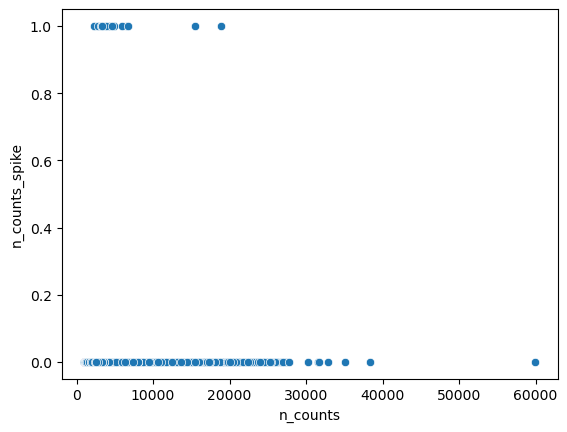

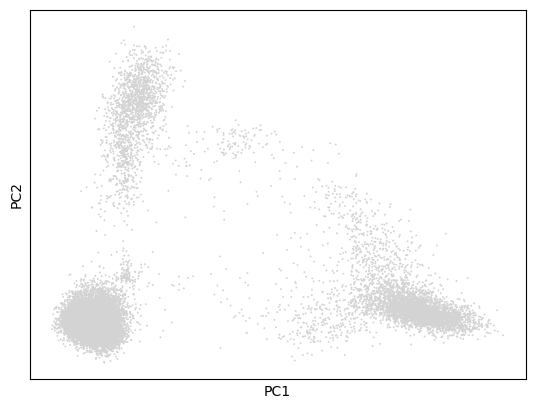

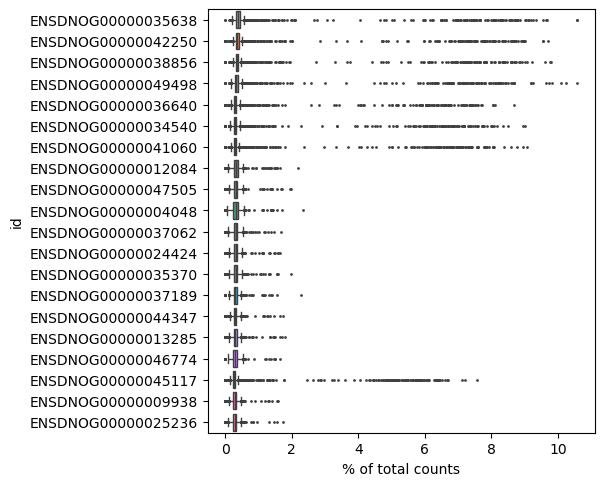

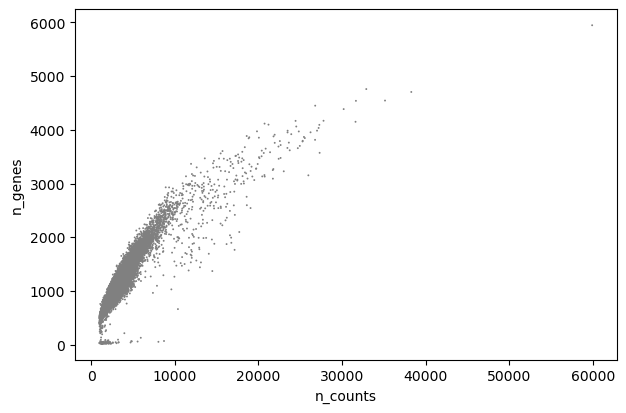

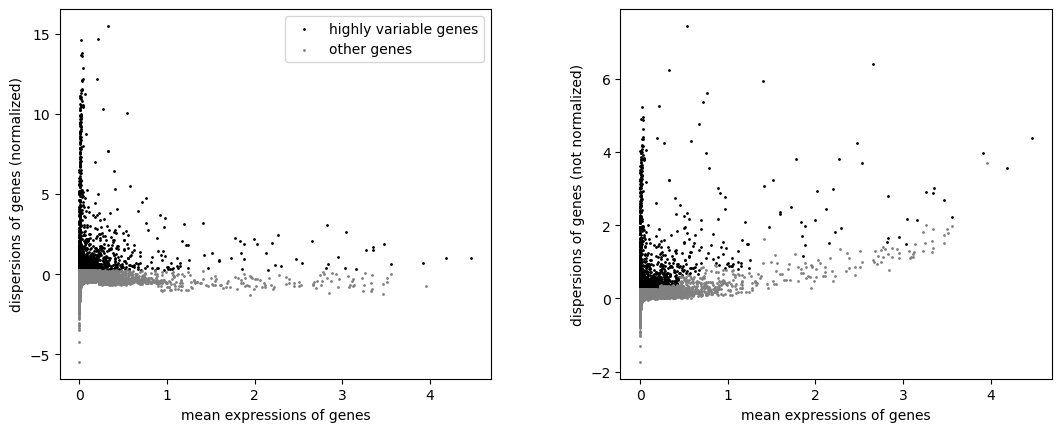

In [7]:
for filt in ['raw', 'filtered'][1:2]:
    with open('scarmadillo_'+filt+'_scobj.pyn','rb') as f:
        all_cells = pickle.load(f)
        print(all_cells)
        print(all_cells.var)
        print(all_cells.obs)
        print(all_cells.X.shape)
        # all_cells.var = all_cells.var.set_index('symbol')
        test_dimension_reduction(all_cells, 'scarmadillo_'+filt)

AnnData object with n_obs × n_vars = 16093 × 33472
    obs: 'barcode', 'batch', 'cov'
    var: 'symbol', 'cov'
                                  symbol    cov  n_cells
id                                                      
ENSDNOG00000042816                  MTDH  13338     7426
ENSDNOG00000018035                TSPYL5     44       35
ENSDNOG00000036192                   CPQ    119      103
ENSDNOG00000001330                PTDSS1    135      133
ENSDNOG00000041739                MTERF3    449      431
...                                  ...    ...      ...
ENSDNOG00000042957    ENSDNOG00000042957      6        6
ENSDNOG00000044297    ENSDNOG00000044297   1046      883
gSpikein_ERCC-00054  gSpikein_ERCC-00054      1        1
gSpikein_phiX174        gSpikein_phiX174     15       15
CD4                                  CD4   2302     1862

[20530 rows x 3 columns]
                  barcode  batch   cov  n_genes
0-0      AAACCCACAGCACCCA      0  3151     1134
1-0      AAACCCACATGACAAA 

/var/folders/fp/rc9qnfl53b76r8pj1kppjvr00000gq/T/ipykernel_94485/2886896120.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p1 = sns.distplot(all_cells.obs['n_genes'], kde=False)


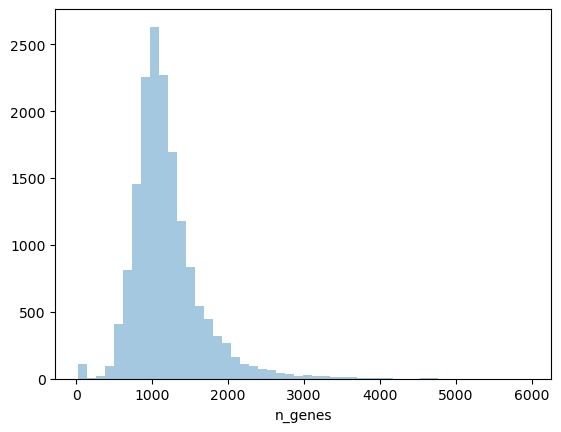

/var/folders/fp/rc9qnfl53b76r8pj1kppjvr00000gq/T/ipykernel_94485/2886896120.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p2 = sns.distplot(all_cells.var['cov'].map(math.log10), kde=False)


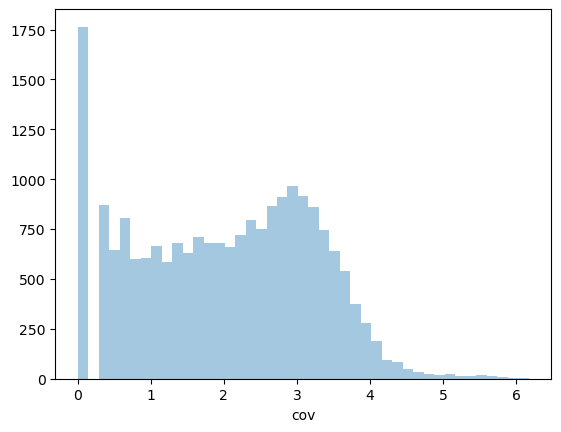

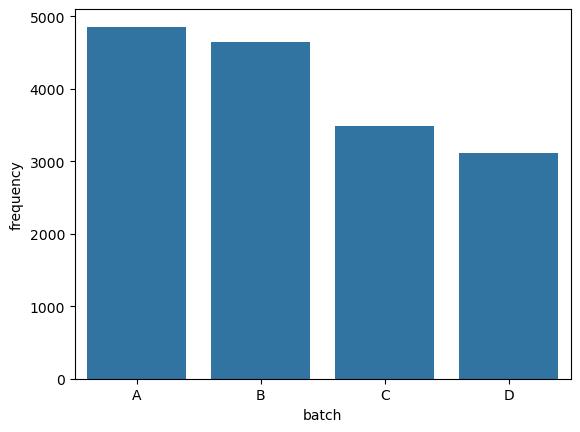

In [8]:
import math

for filt in ['raw', 'filtered'][1:2]:
    with open('scarmadillo_'+filt+'_scobj.pyn','rb') as f:
        all_cells = pickle.load(f)
        print(all_cells)
        sc.pp.filter_cells(all_cells, min_genes=1)
        sc.pp.filter_genes(all_cells, min_cells=1)
        print(all_cells.var)
        print(all_cells.obs)
        print(all_cells.X.shape)
        p1 = sns.distplot(all_cells.obs['n_genes'], kde=False)
        p1.get_figure().savefig('dist_ngenes_'+filt+'.pdf')
        plt.show()
        p2 = sns.distplot(all_cells.var['cov'].map(math.log10), kde=False)
        p2.get_figure().savefig('dist_cov_'+filt+'.pdf')
        plt.show()
        df = all_cells.obs['batch'].value_counts()
        df = df.reset_index()
        df.columns = ['batch', 'frequency'] 
        df.batch = ['A', 'B', 'C', 'D']
        p3 = sns.barplot(data=df, x='batch', y='frequency')
        # p3.legend_.remove()
        p3.get_figure().savefig('bar_batch_ccount'+filt+'.pdf')
        plt.show()
        

In [10]:
def add_dimension_reduction(adata, batch_header, resolution=None):  
    adata = data_preprocess(adata)
    print(adata)
    color = 'batch'
    n_top_genes, pc, nn, perplexity, learning_rate = 2000, 50, 30, 30, 100
    adata = data_postprocess(adata, n_top_genes, '_'+batch_header+'_pca_plot.png')
    print(adata)
    sc.pl.pca_loadings(adata, save=batch_header+'_pca.png')
    sc.pl.pca_variance_ratio(adata, save=batch_header+'_pca_var.png')
    sc.pp.neighbors(adata, n_neighbors=nn, n_pcs=pc, method='umap')
    sc.tl.umap(adata)
    sc.tl.tsne(adata, n_pcs=pc, perplexity=perplexity, learning_rate=learning_rate)
    check_data_property(adata, batch_header)
    adata.X = adata.raw.X
    adata.obs['tsne1'] = adata.obsm['X_tsne'][:,0]
    adata.obs['tsne2'] = adata.obsm['X_tsne'][:,1]
    adata.obs['umap1'] = adata.obsm['X_umap'][:,0]
    adata.obs['umap2'] = adata.obsm['X_umap'][:,1]
    sc.tl.louvain(adata, resolution=resolution, copy=False, key_added='cluster_louvain')
    sc.tl.leiden(adata, resolution=resolution, copy=False, key_added='cluster_leiden')
    return adata

def plot_ranking_genes(adata, batch_header, cluster=['cluster_louvain', 'cluster_leiden', 'celltype']):
    for color in cluster:
        assigned_cells = [c for c in set(adata.obs[color]) if (adata[adata.obs[color] == c].shape[0] > 1) and c == c]
        tdata = adata[[(c in assigned_cells) for c in adata.obs[color]], :]
        sc.tl.rank_genes_groups(tdata, groupby=color, method='wilcoxon', n_genes=10000)
        df = pd.DataFrame([list(x) for x in tdata.uns['rank_genes_groups']['names']])
        df.columns = tdata.obs[color].cat.categories
        df.to_csv(batch_header+"_rank_genes_"+color+'.csv')
        sc.pl.rank_genes_groups(tdata, n_genes=15, save=batch_header+"_rank_genes_"+color+".pdf")
        del tdata.uns['rank_genes_groups']

def plot_tsne_and_umap(adata, batch_header, label, cluster=['cluster_louvain', 'cluster_leiden', 'celltype']):
    for color in cluster+['cov', 'batch']:
        palette = None
        for loc in ['on data', 'right margin']:
            print(color, label)
            ofile = os.path.join(batch_header+"_ori_"+label+"_"+color+("_on" if loc == 'on data' else '')+".pdf")
            kwargs = {'edgecolor':None, 'alpha':0.4}
            sc.pl.scatter(adata, x=label+'1', y=label+'2', color=color, palette=palette, legend_loc=loc, save=ofile)
            
def analyze_and_visualize(adata, batch_header, resolution=None):
    for label in ['tsne', 'umap']:
        plot_tsne_and_umap(adata, batch_header, label)
        #plot_marker_genes_embedded(adata, out, label, markers)
        #self.plot_agg_marker_genes(adata, out, markers)
    plot_ranking_genes(adata, batch_header)

In [16]:
import leidenalg

['gSpikein_ERCC-00002', 'gSpikein_ERCC-00003', 'gSpikein_ERCC-00004', 'gSpikein_ERCC-00007', 'gSpikein_ERCC-00009', 'gSpikein_ERCC-00012', 'gSpikein_ERCC-00013', 'gSpikein_ERCC-00014', 'gSpikein_ERCC-00016', 'gSpikein_ERCC-00017', 'gSpikein_ERCC-00018', 'gSpikein_ERCC-00019', 'gSpikein_ERCC-00022', 'gSpikein_ERCC-00023', 'gSpikein_ERCC-00024', 'gSpikein_ERCC-00025', 'gSpikein_ERCC-00028', 'gSpikein_ERCC-00031', 'gSpikein_ERCC-00033', 'gSpikein_ERCC-00034', 'gSpikein_ERCC-00035', 'gSpikein_ERCC-00039', 'gSpikein_ERCC-00040', 'gSpikein_ERCC-00041', 'gSpikein_ERCC-00042', 'gSpikein_ERCC-00043', 'gSpikein_ERCC-00044', 'gSpikein_ERCC-00046', 'gSpikein_ERCC-00048', 'gSpikein_ERCC-00051', 'gSpikein_ERCC-00053', 'gSpikein_ERCC-00054', 'gSpikein_ERCC-00057', 'gSpikein_ERCC-00058', 'gSpikein_ERCC-00059', 'gSpikein_ERCC-00060', 'gSpikein_ERCC-00061', 'gSpikein_ERCC-00062', 'gSpikein_ERCC-00067', 'gSpikein_ERCC-00069', 'gSpikein_ERCC-00071', 'gSpikein_ERCC-00073', 'gSpikein_ERCC-00074', 'gSpikein_

/usr/local/Caskroom/miniforge/base/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


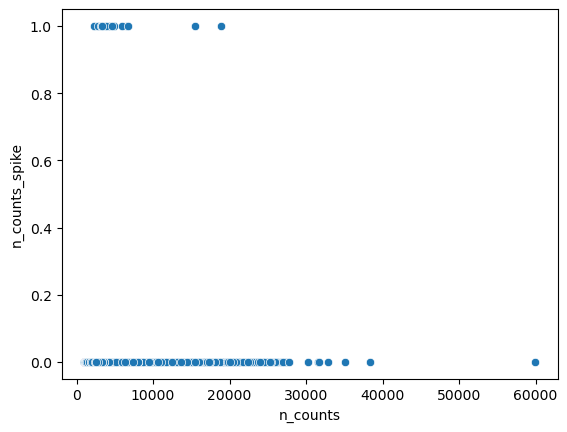

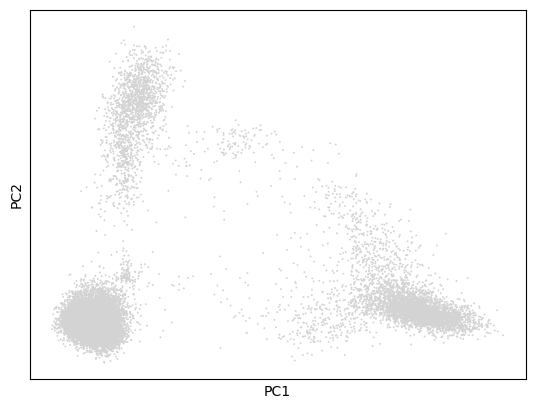

AnnData object with n_obs × n_vars = 16093 × 15413
    obs: 'barcode', 'batch', 'cov', 'n_counts_spike', 'n_counts'
    var: 'symbol', 'cov', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


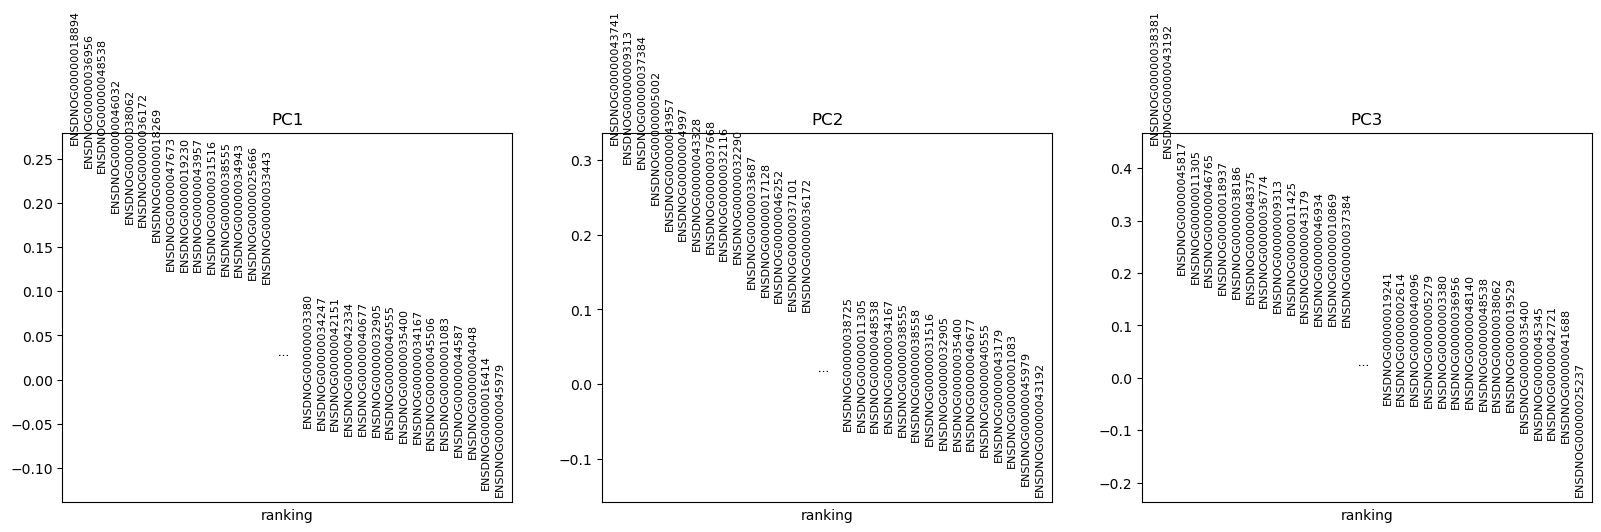

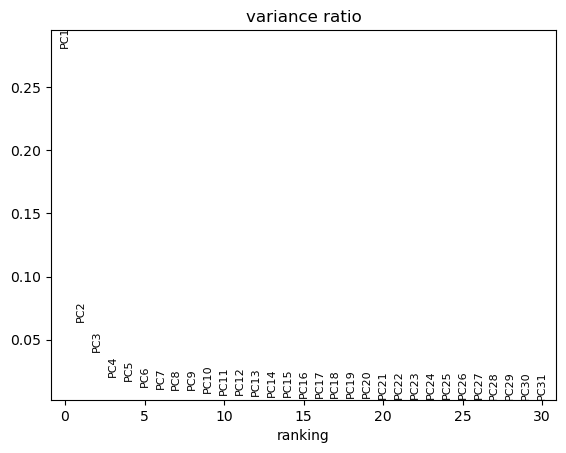

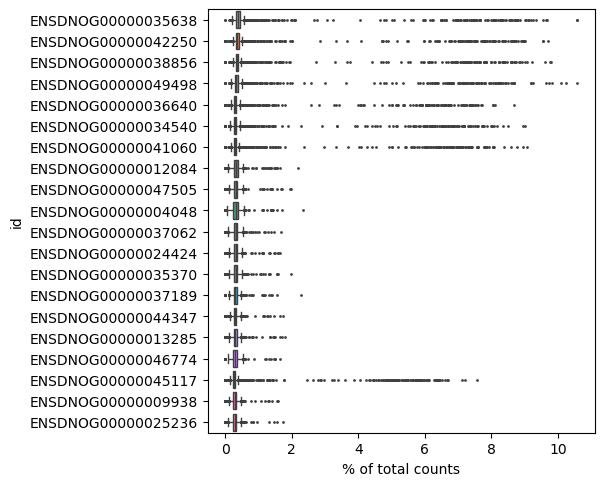

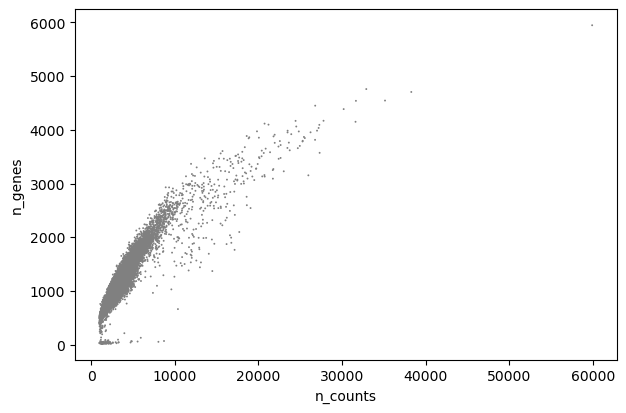

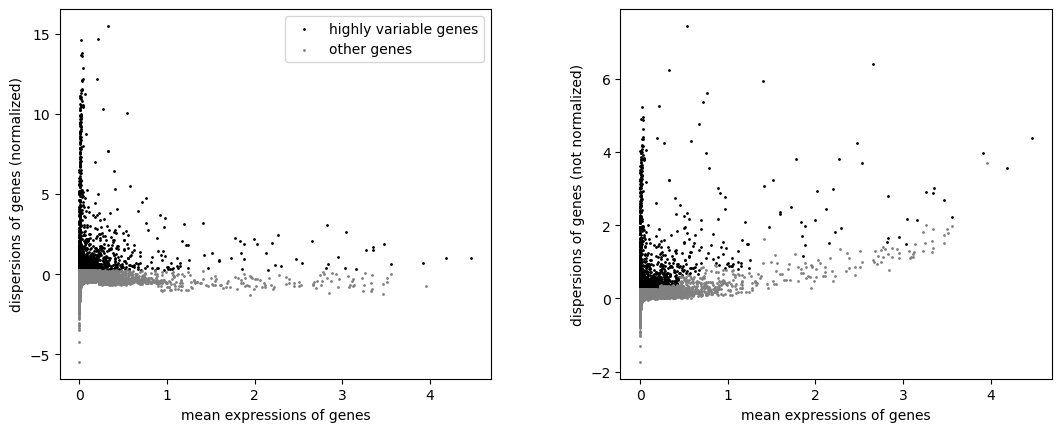

/var/folders/fp/rc9qnfl53b76r8pj1kppjvr00000gq/T/ipykernel_94485/1782411.py:20: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=resolution, copy=False, key_added='cluster_leiden')


                                symbol    cov  n_counts  highly_variable  \
id                                                                         
ENSDNOG00000042816                MTDH  13338   13338.0            False   
ENSDNOG00000018035              TSPYL5     44      44.0             True   
ENSDNOG00000036192                 CPQ    119     119.0            False   
ENSDNOG00000001330              PTDSS1    135     135.0            False   
ENSDNOG00000041739              MTERF3    449     449.0            False   
...                                ...    ...       ...              ...   
ENSDNOG00000042001  ENSDNOG00000042001     34      34.0            False   
ENSDNOG00000033037             TMEM158    139     139.0            False   
ENSDNOG00000031200  ENSDNOG00000031200     29      29.0            False   
ENSDNOG00000044297  ENSDNOG00000044297   1046    1046.0             True   
CD4                                CD4   2302    2302.0             True   

           

In [17]:
for filt in ['raw', 'filtered'][1:2]:
    all_cells = None
    with open('scarmadillo_'+filt+'_scobj.pyn','rb') as f:
        all_cells = pickle.load(f)
        all_cells.var = all_cells.var.reset_index().set_index('id')
        all_cells = add_dimension_reduction(all_cells, 'scarmadillo_'+filt)
    print(all_cells.var)
    if all_cells is None: continue
    with open('scarmadillo_'+filt+'_modf_scobj.pyn', 'wb') as f:
        pickle.dump(all_cells, f)

In [18]:
# cell typing (1st step)
def assign_celltype_by_tsne(x):
    return ['CD4+ T', 'CD14+ Mono', 'CD14+ Mono', 'CD4+ Memory', 'CD4+ Memory', \
    'CD4+ T', 'CD8+ T', 'B', 'CD8+ T', 'B', 'CD4+ T', 'CD14+ Mono', 'B', 'CD14+ Mono', 'DC|FCGR3A+ Mono', 'CD14+ Mono'][int(x)]


AnnData object with n_obs × n_vars = 16093 × 15413
    obs: 'barcode', 'batch', 'cov', 'n_counts_spike', 'n_counts', 'tsne1', 'tsne2', 'umap1', 'umap2', 'cluster_louvain', 'cluster_leiden'
    var: 'symbol', 'cov', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'tsne', 'cluster_louvain', 'cluster_leiden'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
cluster_louvain tsne


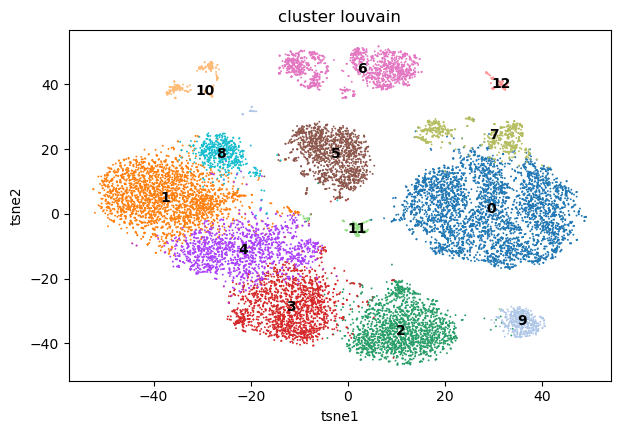

cluster_louvain tsne


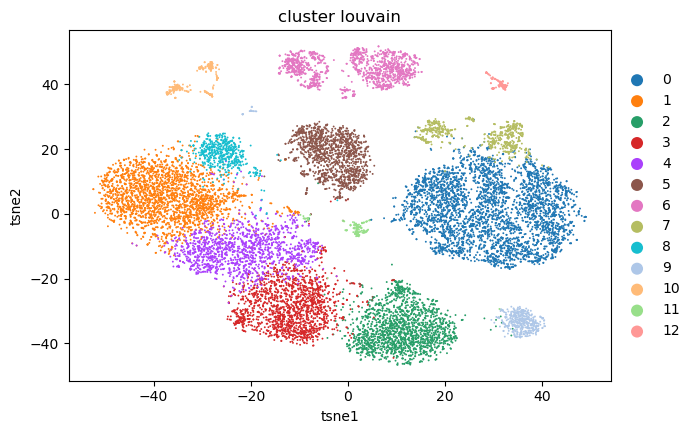

cluster_leiden tsne


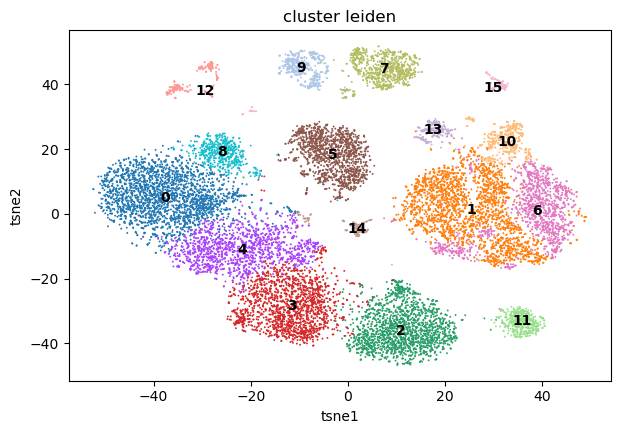

cluster_leiden tsne


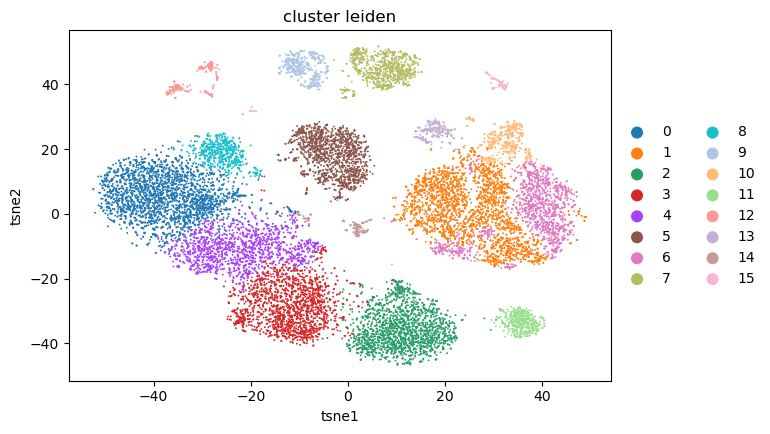

celltype tsne


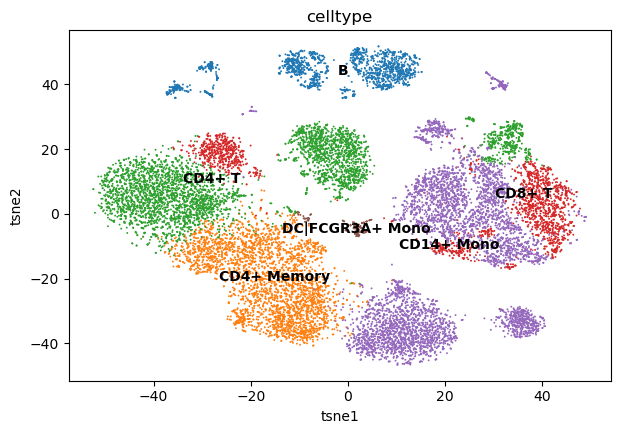

celltype tsne


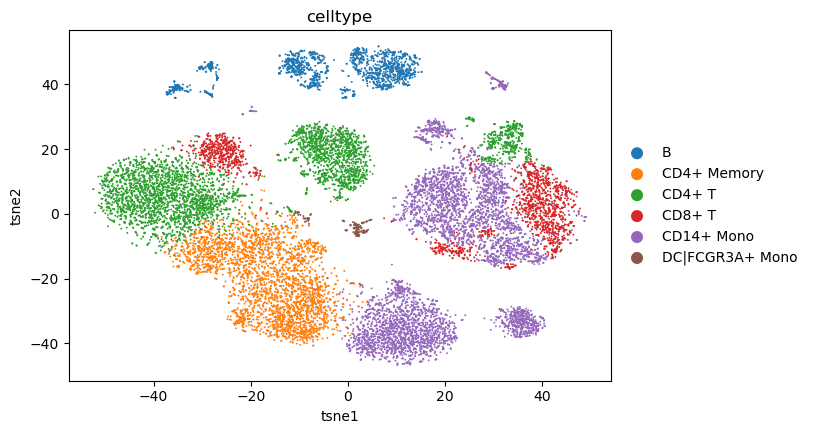

cov tsne


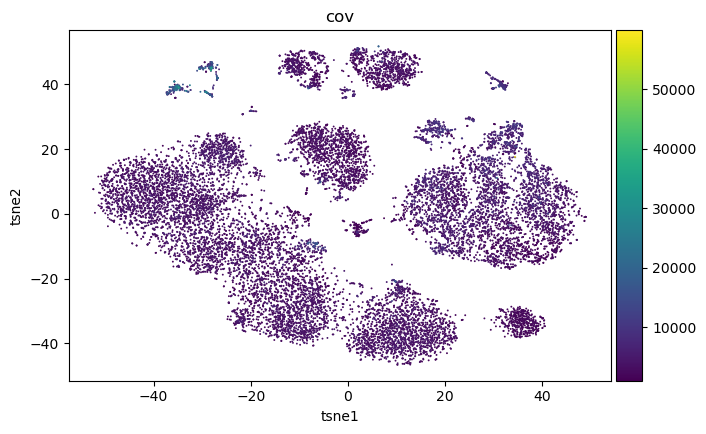

cov tsne


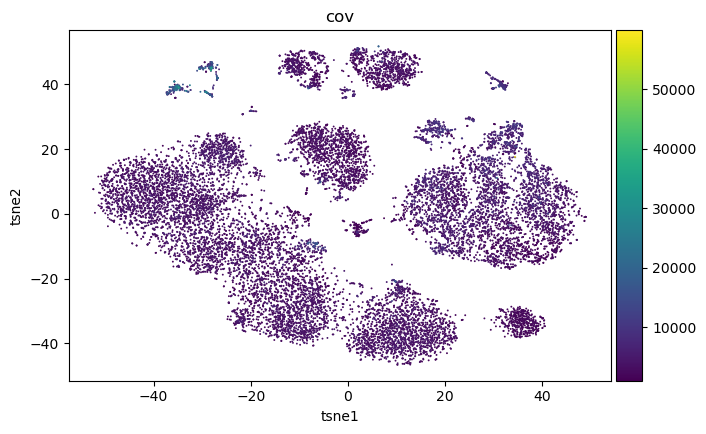

batch tsne


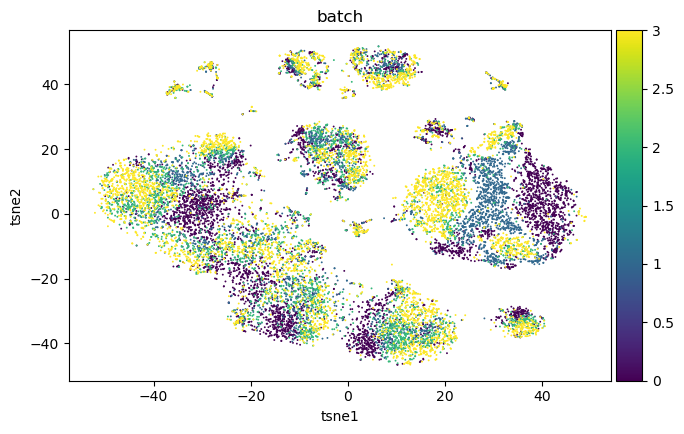

batch tsne


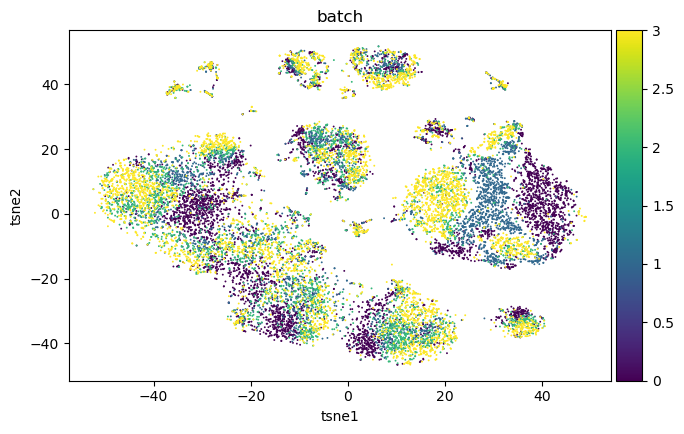

cluster_louvain umap


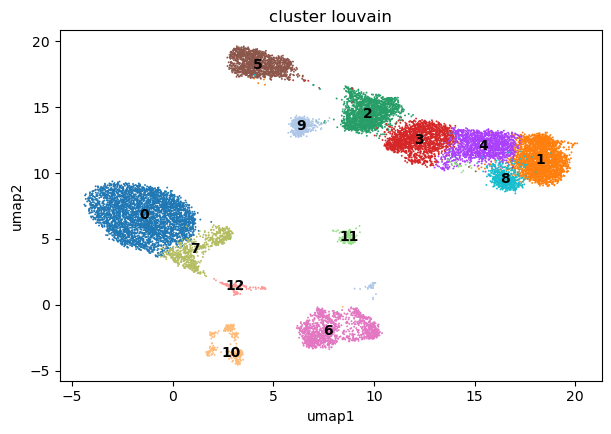

cluster_louvain umap


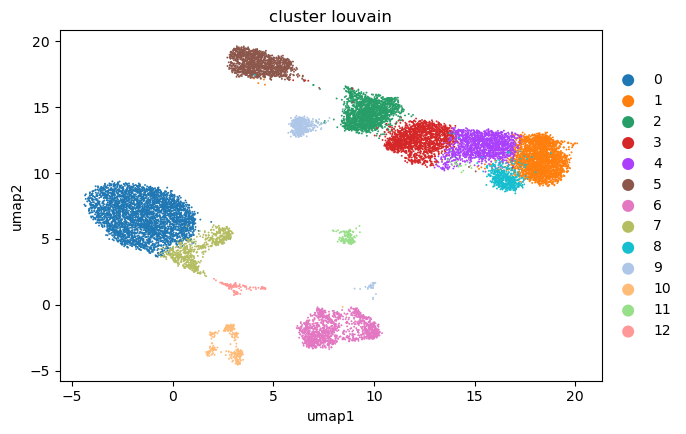

cluster_leiden umap


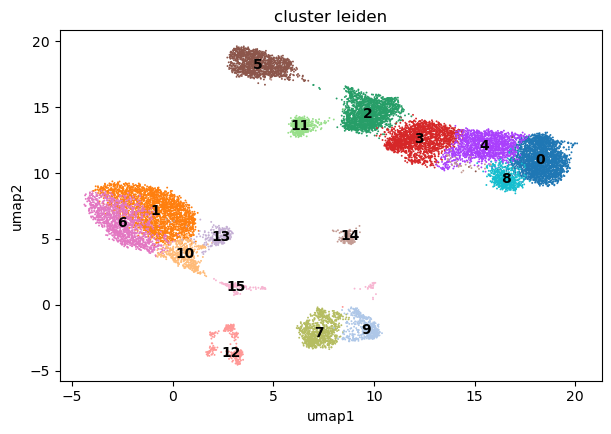

cluster_leiden umap


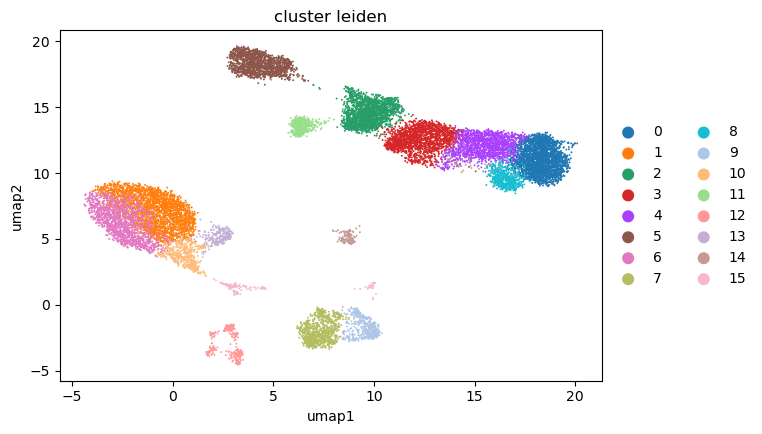

celltype umap


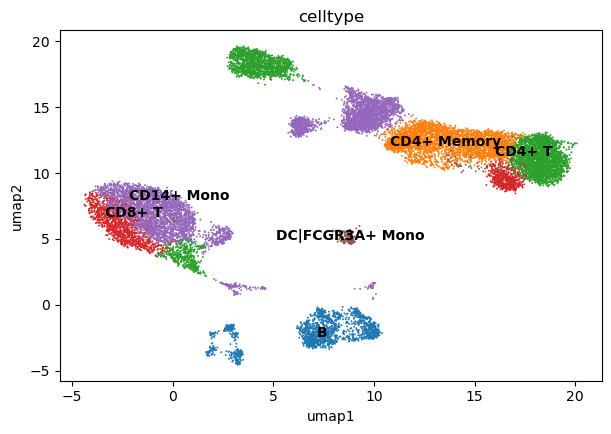

celltype umap


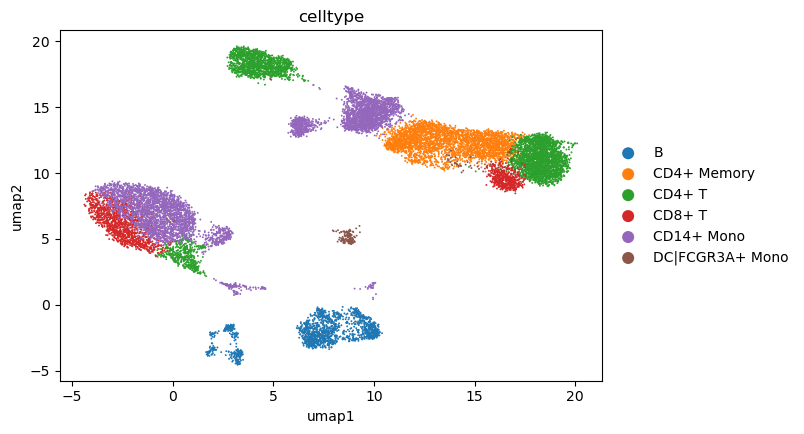

cov umap


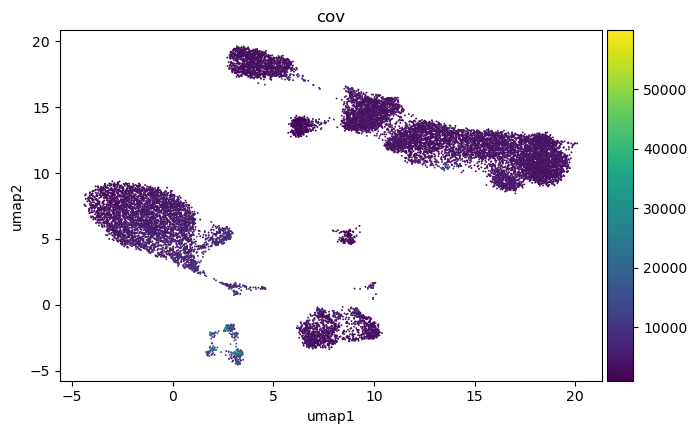

cov umap


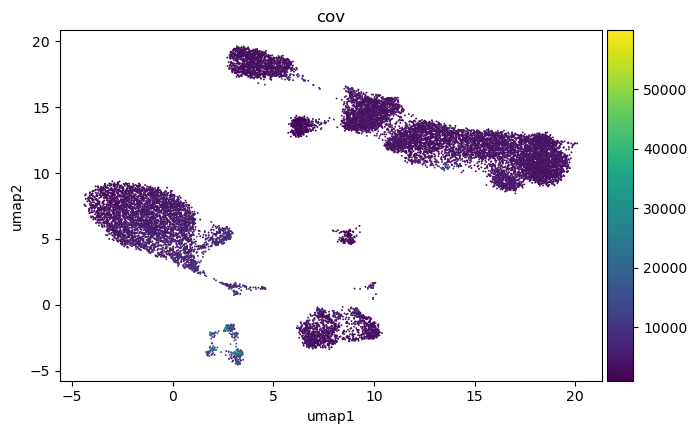

batch umap


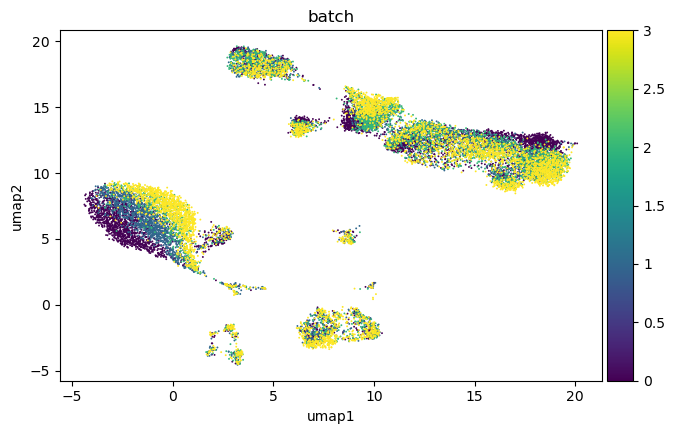

batch umap


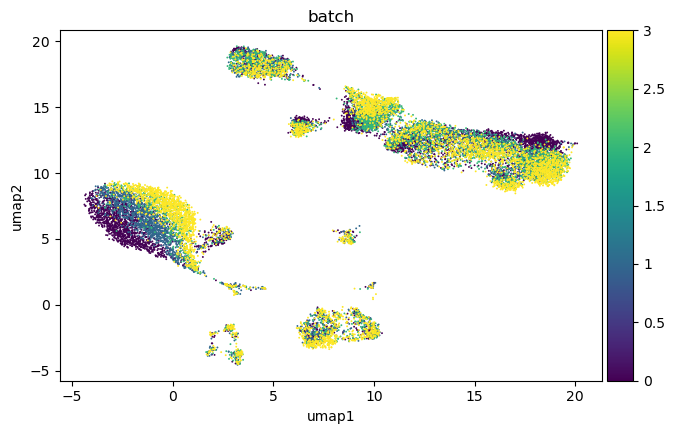

/usr/local/Caskroom/miniforge/base/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


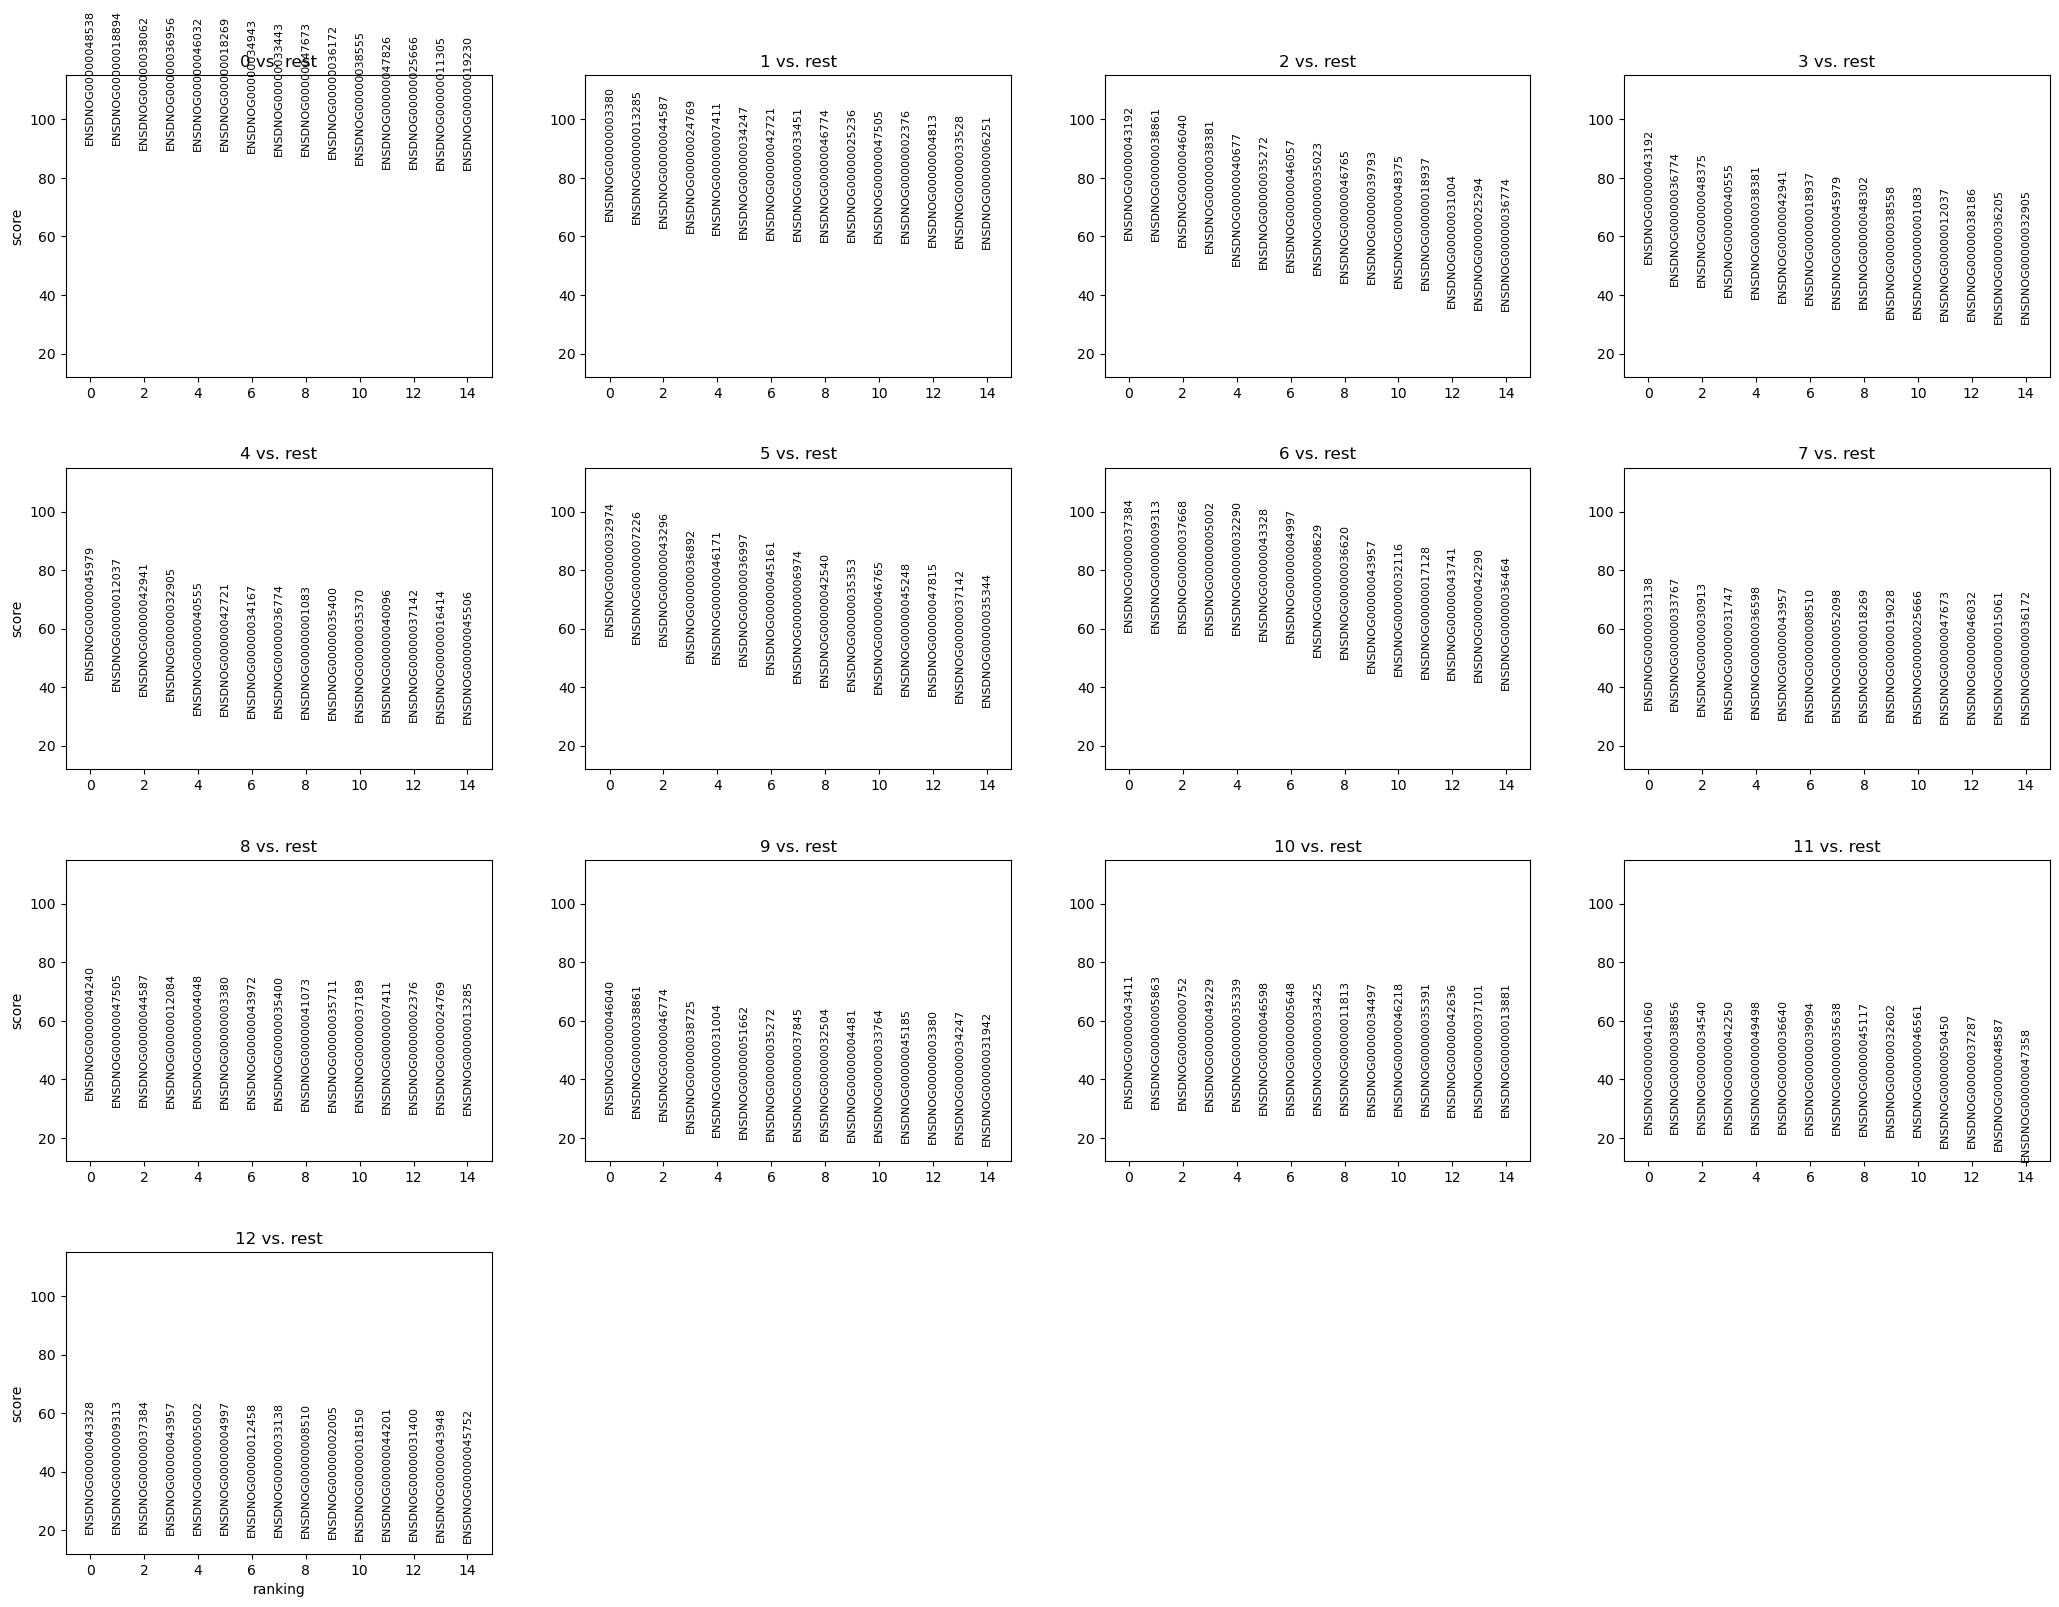

/usr/local/Caskroom/miniforge/base/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


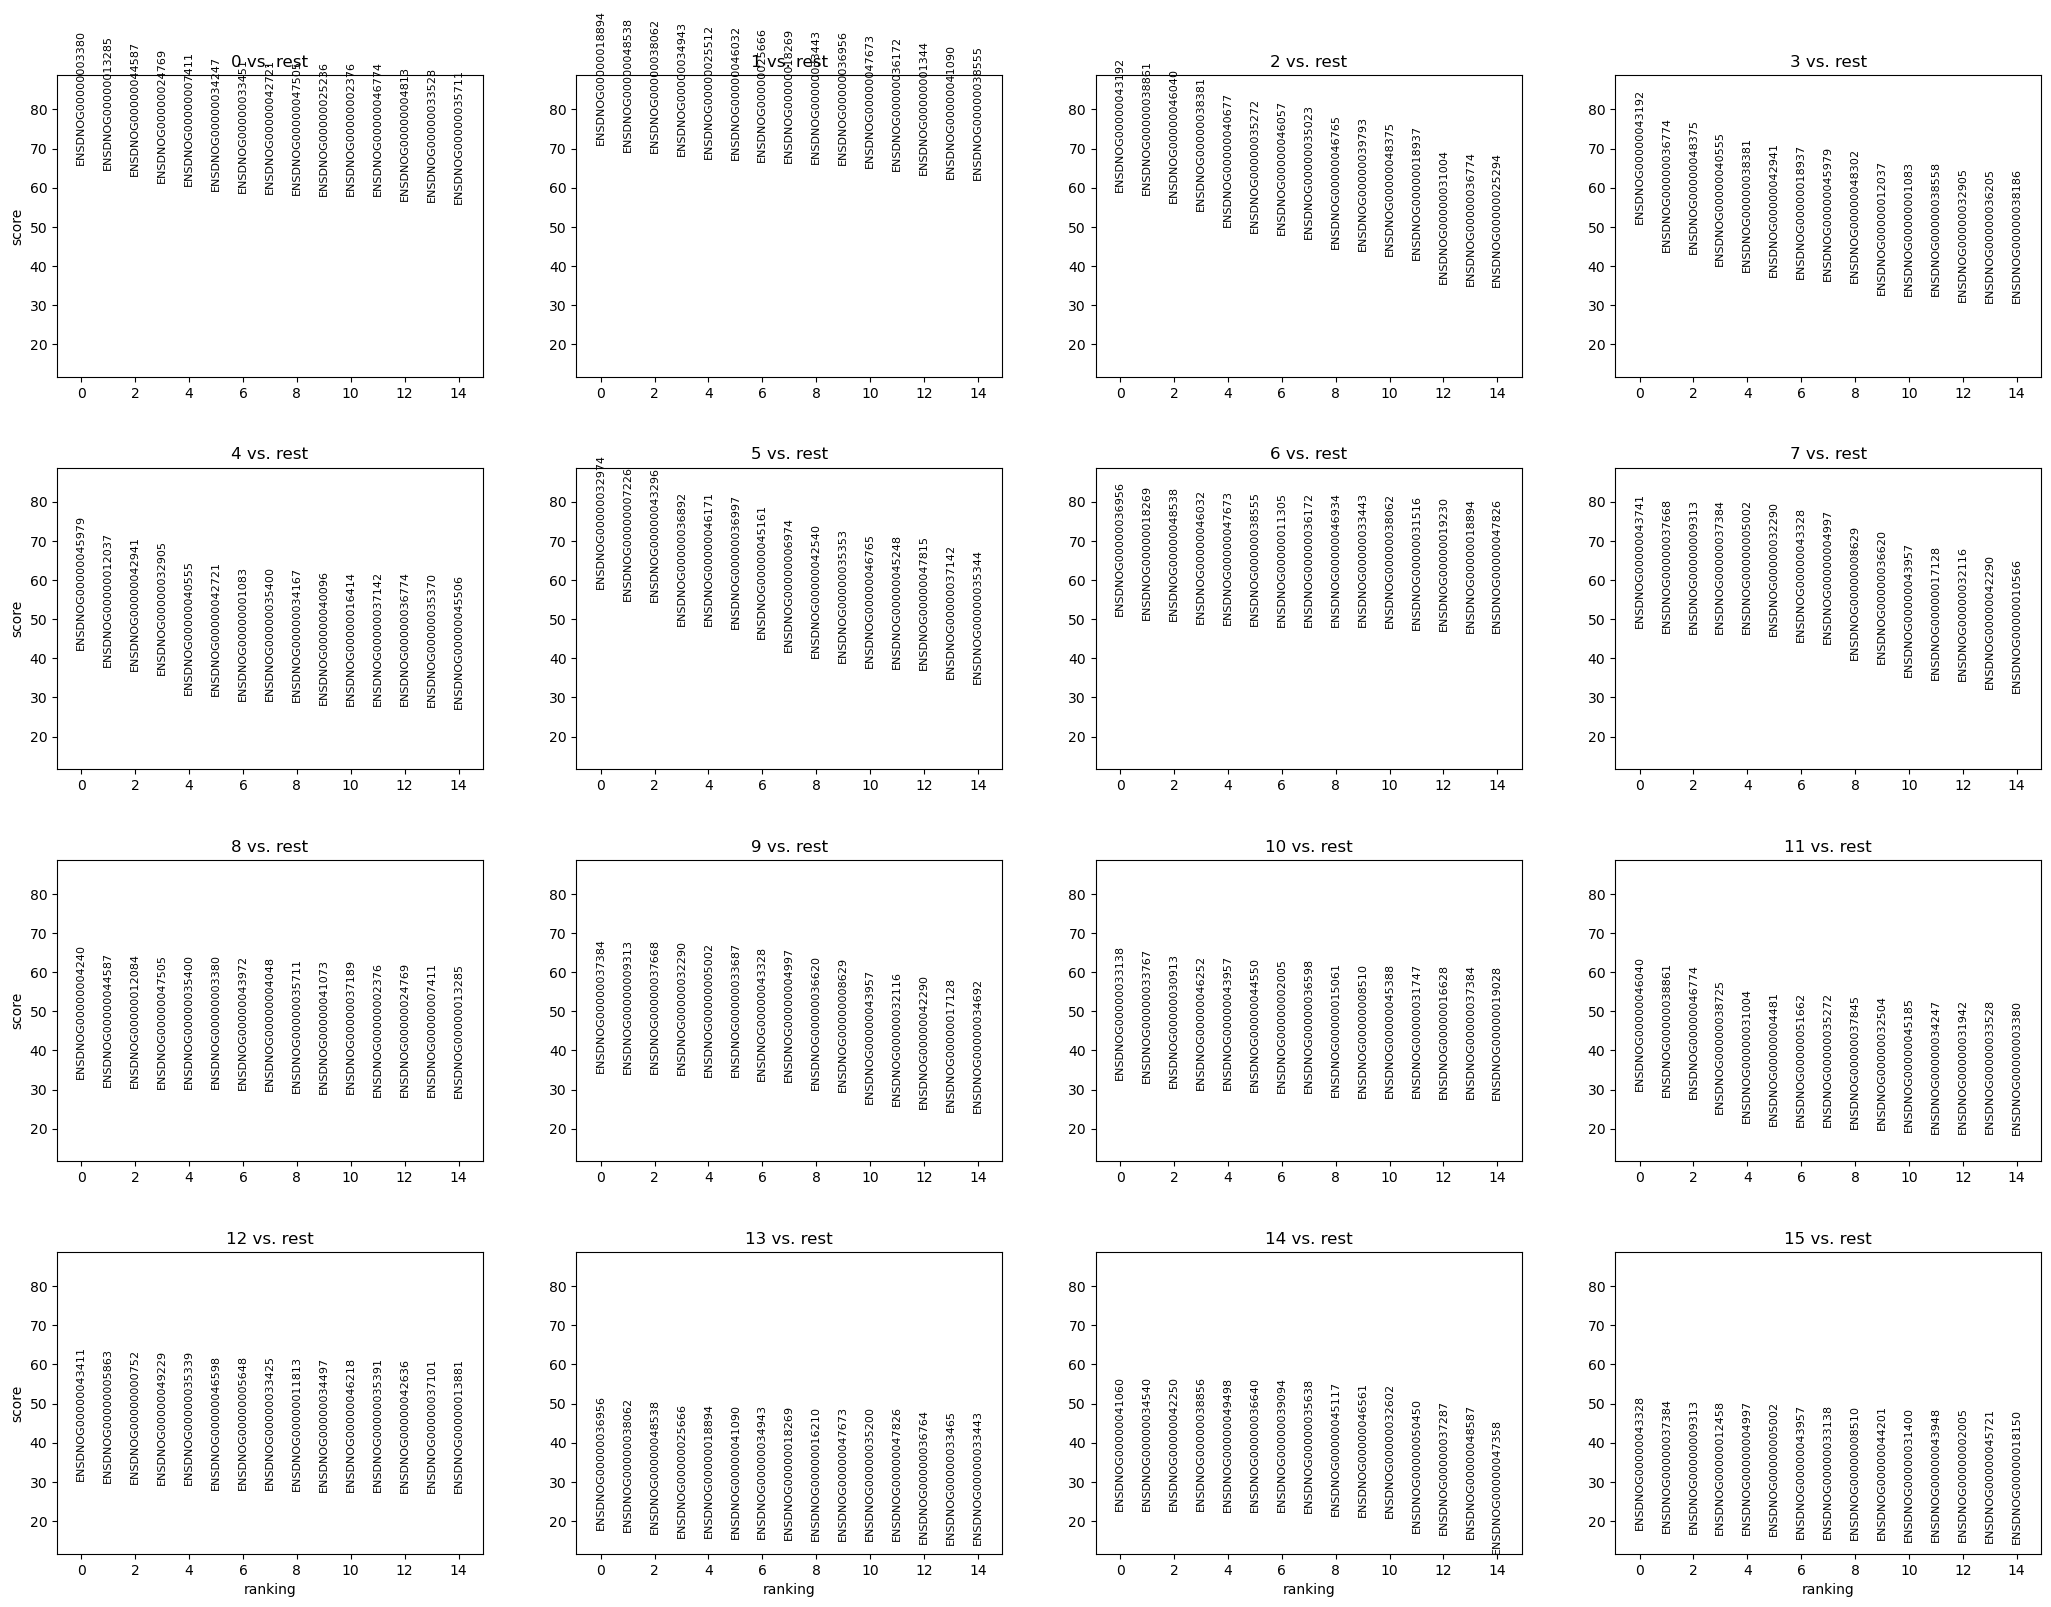

/usr/local/Caskroom/miniforge/base/envs/scanpy/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


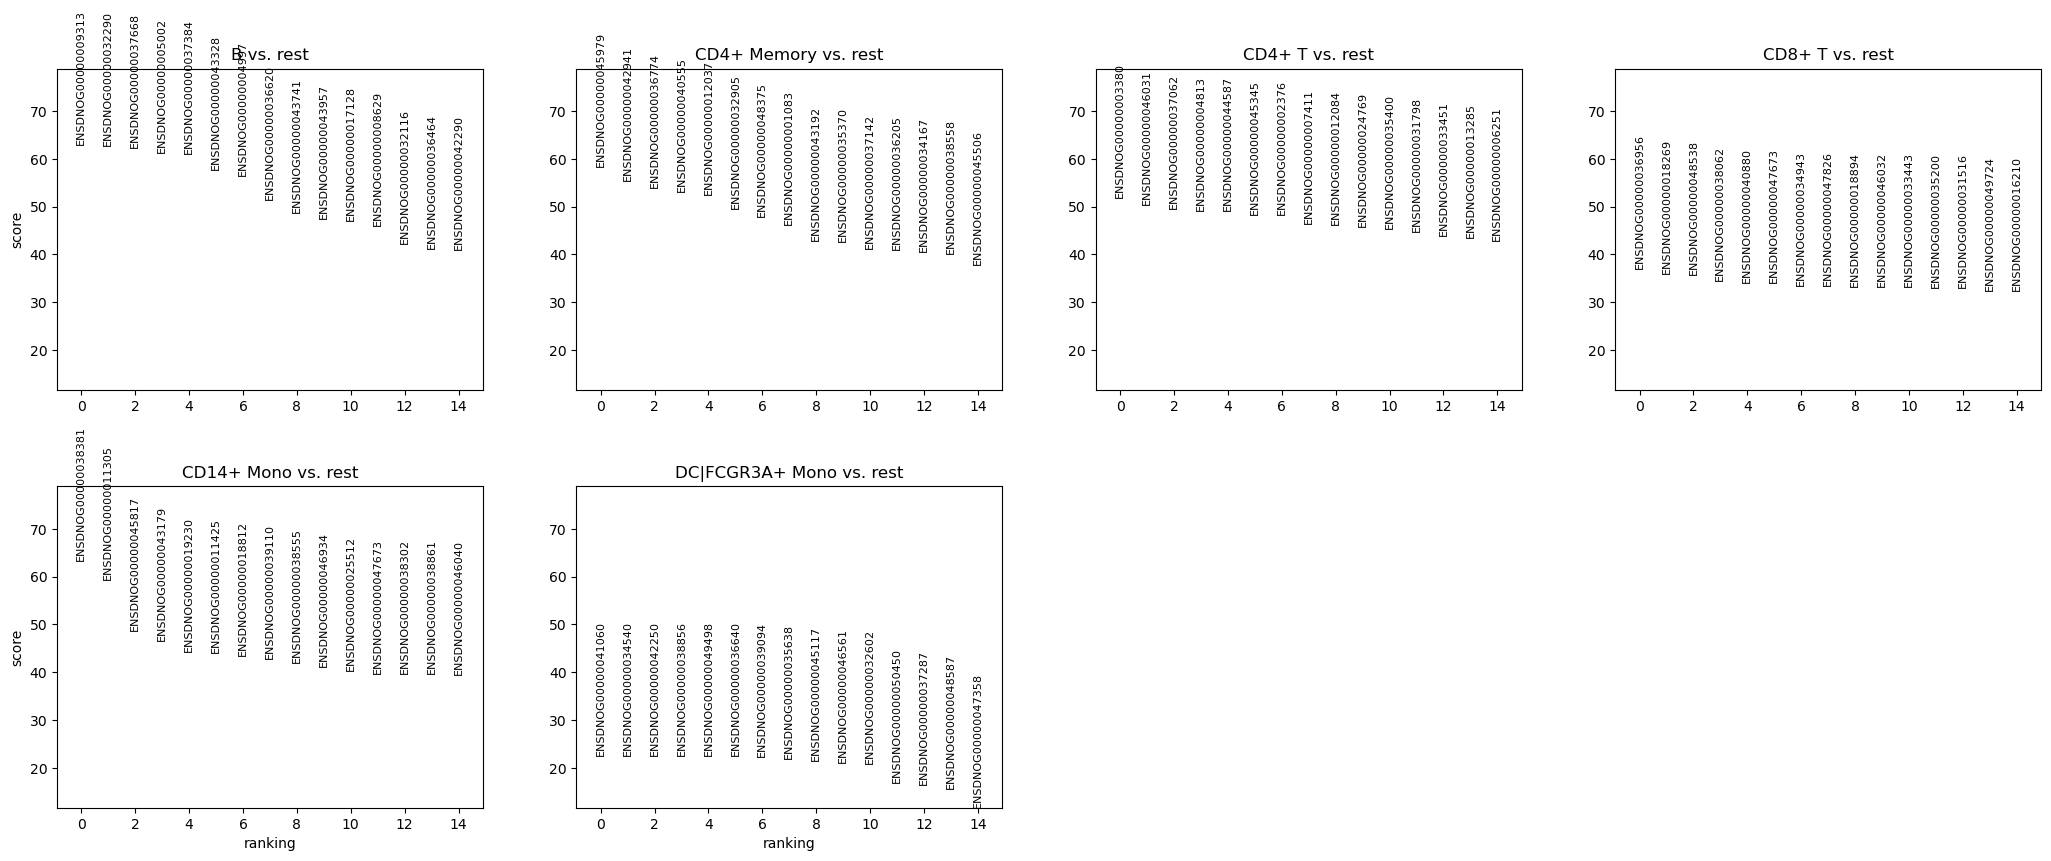

In [19]:
for filt in ['raw', 'filtered'][1:2]:
    all_cells = None
    with open('scarmadillo_'+filt+'_modf_scobj.pyn', 'rb') as f:
        all_cells = pickle.load(f)
        print(all_cells)
    all_cells.obs.loc[:,'celltype'] = [assign_celltype_by_tsne(x) for x in all_cells.obs.loc[:,'cluster_leiden']]
    analyze_and_visualize(all_cells, 'scarmadillo_'+filt)

           celltype  batch  count   percent
0                 B      0    369  0.076004
1       CD4+ Memory      0   1057  0.217714
2            CD4+ T      0   1205  0.248198
3            CD8+ T      0   1364  0.280947
4        CD14+ Mono      0    824  0.169722
5   DC|FCGR3A+ Mono      0     36  0.007415
6                 B      1    280  0.090032
7       CD4+ Memory      1    486  0.156270
8            CD4+ T      1    837  0.269132
9            CD8+ T      1    129  0.041479
10       CD14+ Mono      1   1343  0.431833
11  DC|FCGR3A+ Mono      1     35  0.011254
12                B      2    323  0.092603
13      CD4+ Memory      2    832  0.238532
14           CD4+ T      2   1044  0.299312
15           CD8+ T      2    143  0.040998
16       CD14+ Mono      2   1104  0.316514
17  DC|FCGR3A+ Mono      2     42  0.012041
18                B      3    660  0.142241
19      CD4+ Memory      3    822  0.177155
20           CD4+ T      3   1163  0.250647
21           CD8+ T      3    19

/var/folders/fp/rc9qnfl53b76r8pj1kppjvr00000gq/T/ipykernel_94485/3692656152.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_ratio = all_cells.obs.loc[:, ['batch', 'celltype']].groupby(['batch', 'celltype']).size()


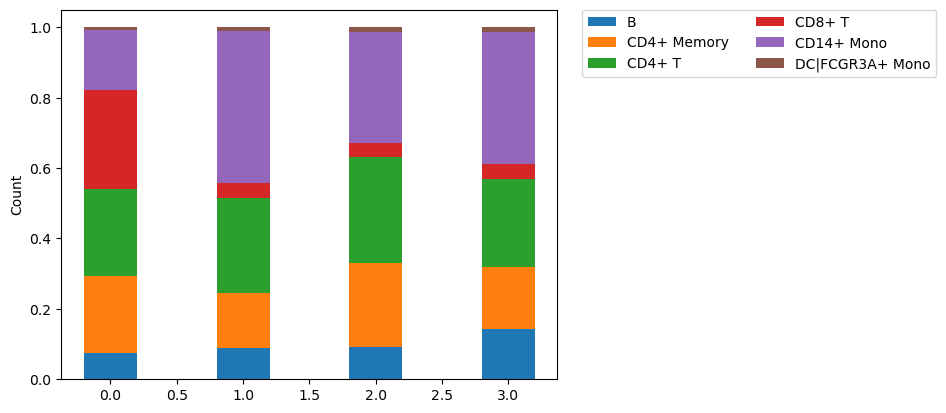

<Figure size 640x480 with 0 Axes>

In [26]:
celltype_ratio = all_cells.obs.loc[:, ['batch', 'celltype']].groupby(['batch', 'celltype']).size()
celltype_ratio = celltype_ratio.reset_index().set_index('celltype')
celltype_ratio = celltype_ratio.assign(percent=celltype_ratio.groupby(['batch']).transform(lambda x: x/sum(x))).reset_index()
celltype_ratio.columns = ['celltype', 'batch', 'count', 'percent']
print(celltype_ratio)
plots = []
stacked = np.array([0, 0, 0, 0])
for i in range(0, 4):
    print(celltype_ratio.loc[celltype_ratio.loc[:,'batch'] == str(i),'percent'].sum())
for c in celltype_ratio.loc[:,'celltype'].unique():
    temp = celltype_ratio.loc[celltype_ratio.loc[:,'celltype'] == c,:]
    plots.append(plt.bar(temp.loc[:,'batch'], temp.loc[:,'percent'], 0.4, bottom=stacked))
    if stacked is None:
        stacked = temp.loc[:, 'percent'].values
    else:
        stacked = stacked + temp.loc[:,'percent'].values

plt.ylabel('Count')
plt.legend((x[0] for x in plots), tuple(celltype_ratio.loc[:,'celltype'].unique()), bbox_to_anchor=(1.05, 1), loc=2, ncol=2, borderaxespad=0.)
plt.show()
plt.savefig('batch_celltype_ratio.pdf', bbox_inches='tight')
plt.close('all')
plt.clf()

AnnData object with n_obs × n_vars = 16093 × 15413
    obs: 'barcode', 'batch', 'cov', 'n_counts_spike', 'n_counts', 'tsne1', 'tsne2', 'umap1', 'umap2', 'cluster_louvain', 'cluster_leiden'
    var: 'symbol', 'cov', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'tsne', 'cluster_louvain', 'cluster_leiden'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'
                                symbol    cov  n_counts  highly_variable  \
id                                                                         
ENSDNOG00000042816                MTDH  13338   13338.0            False   
ENSDNOG00000018035              TSPYL5     44      44.0             True   
ENSDNOG00000036192                 CPQ    119     119.0            False   
ENSDNOG00000001330              PTDSS1    135     135.0            False   
ENSDNOG00000041739              MTERF3    449     449.0         

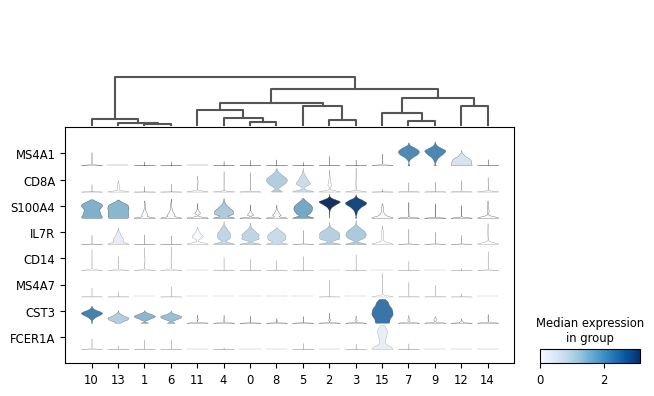

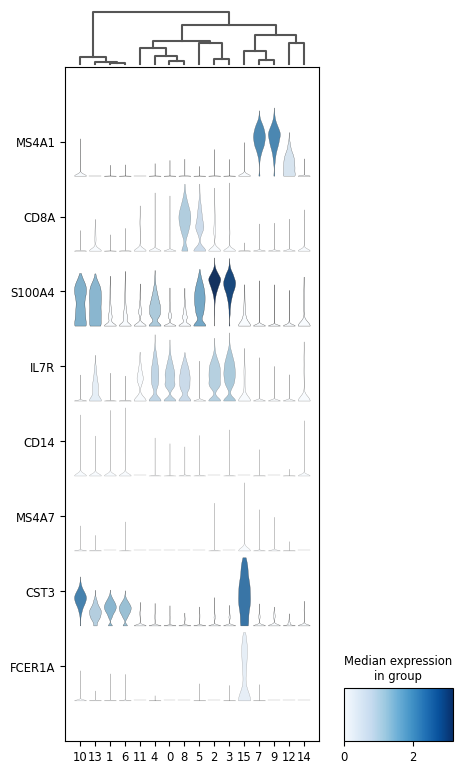

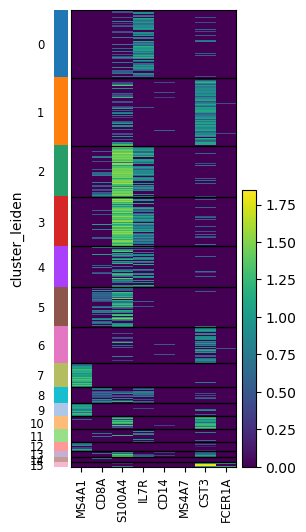

7 ['MS4A1', 'CD8A', 'CST3', 'CD79A', 'LGALS3', 'FCER1A', 'KLRB1']


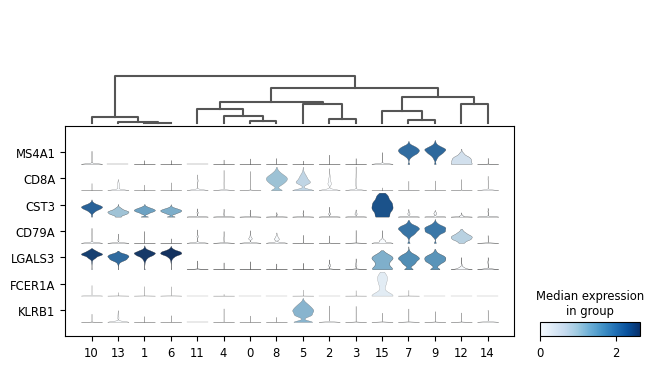

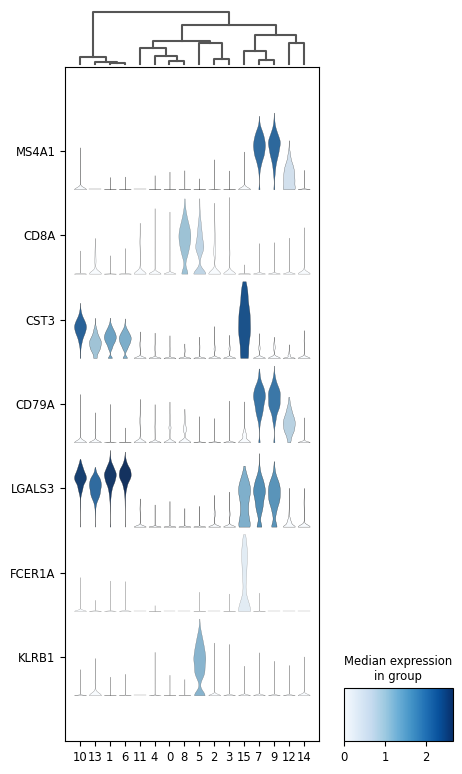

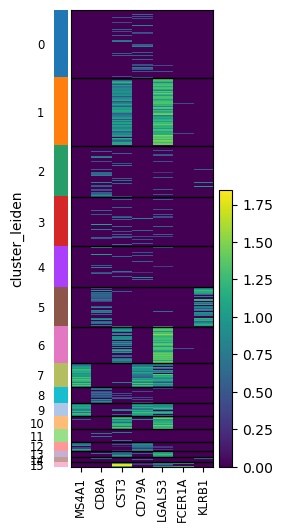

3 ['MS4A1', 'IL7R', 'S100A4']


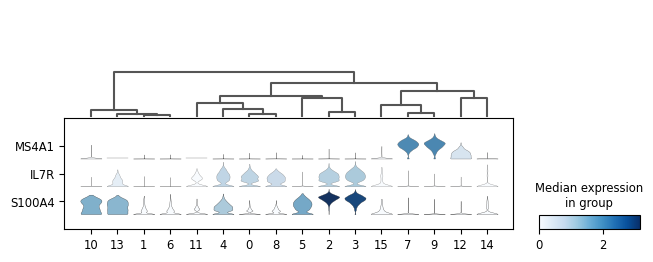

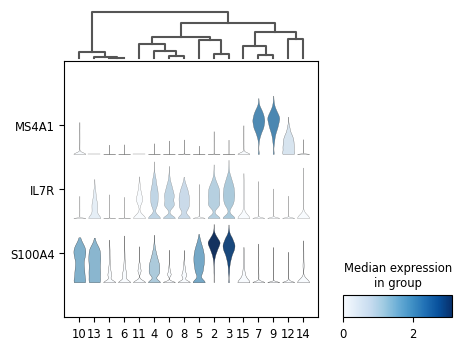

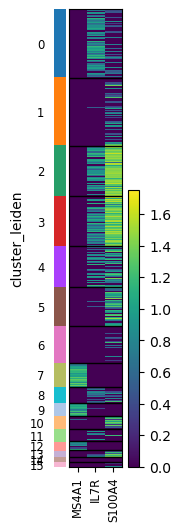

11 ['MS4A1', 'CD8A', 'S100A4', 'IL7R', 'CD14', 'MS4A7', 'CST3', 'CD79A', 'LGALS3', 'FCER1A', 'KLRB1']


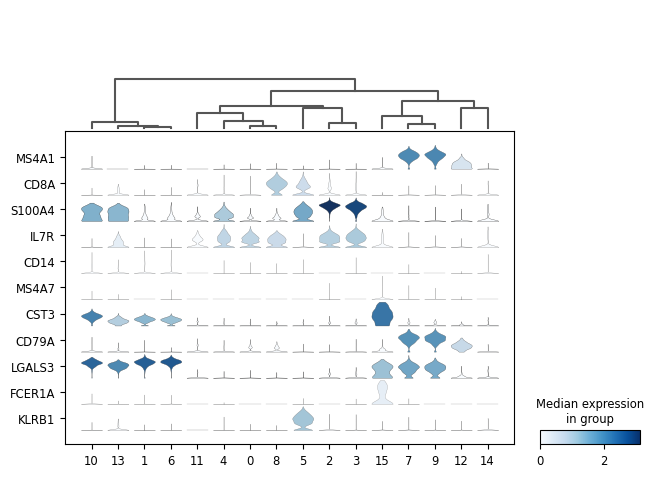

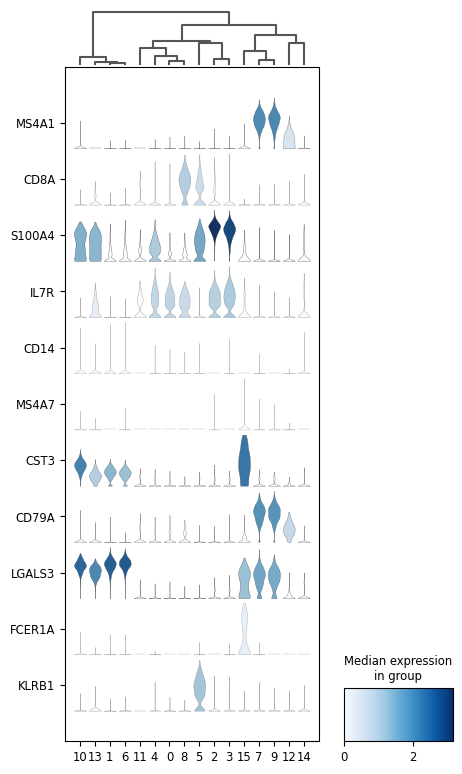

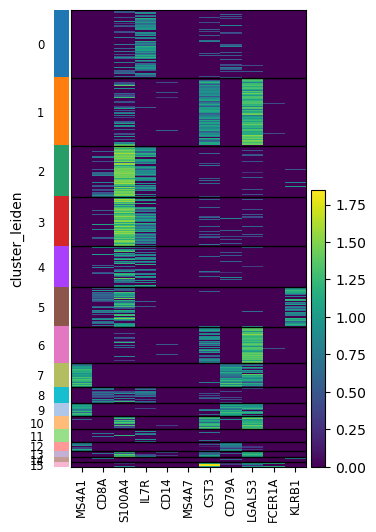

(16093,)
0-0        0.000000
10315-2    0.000000
10316-2    0.000000
10318-2    0.000000
10319-2    0.000000
             ...   
13048-3    0.639661
11807-3    0.642687
12079-3    0.648501
14812-3    0.649398
14907-3    0.663894
Name: MS4A1, Length: 16093, dtype: float32
(16093,)
0-0        0.000000
10301-2    0.000000
10303-2    0.000000
10304-2    0.000000
10305-2    0.000000
             ...   
7331-1     0.518276
7143-1     0.518667
14229-3    0.520939
12103-3    0.521632
3141-0     0.526802
Name: CD8A, Length: 16093, dtype: float32
(16093,)
8046-2     0.000000
10949-2    0.000000
4929-1     0.000000
4927-1     0.000000
10951-2    0.000000
             ...   
8751-2     0.740964
4983-1     0.743061
7254-1     0.745248
10376-2    0.760163
6065-1     0.763542
Name: S100A4, Length: 16093, dtype: float32
(16093,)
8046-2     0.000000
7040-1     0.000000
13337-3    0.000000
13335-3    0.000000
7044-1     0.000000
             ...   
11020-2    0.574643
14113-3    0.578032
15553-3    0.57

<Figure size 640x480 with 0 Axes>

In [48]:
def plot_seaborn_scatter(data, x, y, hue, out, kwargs, annot=False):
    data = data.sort_values(hue)
    if True:
        plt.figure(figsize=(10,5.5))
        ax = plt.scatter(data.loc[:,x], data.loc[:,y],
                         c=data.loc[:,hue], cmap=plt.get_cmap('RdYlBu_r'), s=3.5)
        plt.colorbar(ax)
        plt.title("Gene: "+hue)
        #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=2, borderaxespad=0.)
        plt.savefig(out, bbox_inches='tight')
    else:
        ax = sns.scatterplot(x=x, y=y, data=data, hue=hue, s=3.5, **kwargs)
        ax.set_title("Gene: "+hue)
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=2, borderaxespad=0.)
        if annot:
            for line in range(0, data.shape[0]):
                ax.text(data.iloc[line,:][x], data.iloc[line,:][y], str(line), horizontalalignment='left', size='small', color='black')
        fig = ax.get_figure()
        fig.savefig(out, bbox_inches='tight')
    plt.close()
    plt.clf()

def plot_one_gene(ub, adata, out):
    label = "tsne"
    print(adata[:,adata.var.loc[:,'symbol'] == ub].X.toarray().ravel().shape)
    df = pd.DataFrame({'x':all_cells.obs.loc[:,label+"1"], 'y':adata.obs.loc[:,label+"2"], ub:np.log10(1+adata[:,adata.var.loc[:,'symbol'] == ub].X.toarray().ravel())})
    df = df.sort_values(ub, ascending=True)
    print(df.loc[:,ub])
    plot_seaborn_scatter(df, "x", "y", ub, os.path.join("./figures", out+"_"+label+"_"+ub+".pdf"), {'palette':plt.get_cmap('RdYlBu_r'), 'linewidth':0, 'alpha':1.0})

for filt in ['raw', 'filtered'][1:2]:
    all_cells = None
    with open('scarmadillo_'+filt+'_modf_scobj.pyn', 'rb') as f:
        all_cells = pickle.load(f)
        print(all_cells)
        print(all_cells.var)
        #all_cells.var = all_cells.var.reset_index().set_index('symbol')
        print(all_cells.var_names)
        marker_list = [['IL7R', 'CCR7', 'S100A4', 'CD14', 'LYZ', 'MS4A1', 'CD8A', 'FCGR3A', 'MS4A7', 'GNLY', 'NKG7', 'FCER1A', 'CST3', 'PPBP'], \
                       ['CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1', 'FCGR3A', 'FCER1A', 'CST3'], ['S100A4', 'MS4A1', 'IL7R']]
        marker_list.append([y for x in marker_list for y in x])
        for i, marker in enumerate(marker_list):
            marker = [x for x in marker if x in all_cells.var.loc[:,'symbol'].values]
            marker = list(set(marker))
            print(len(marker), marker)
            marker_name = ['seurat', 'scanpy', 'some', 'all']
            ax = sc.pl.stacked_violin(all_cells, marker, gene_symbols='symbol', groupby='cluster_leiden', swap_axes=True, dendrogram=True, save='marker_plot_'+filt+'_'+marker_name[i]+'_marker.png')
            ax = sc.pl.stacked_violin(all_cells, marker, gene_symbols='symbol', figsize=((5, 9.5) if marker_name[i] != 'some' else (5, 4)), groupby='cluster_leiden', swap_axes=True, dendrogram=True, save='marker_plot_'+filt+'_'+marker_name[i]+'_marker.pdf')
            ax = sc.pl.heatmap(all_cells, marker, gene_symbols='symbol', groupby='cluster_leiden', log=True, save='heatmap_'+filt+'_'+marker_name[i]+'_marker.png')
        marker = marker_list[-1]
        marker = [x for x in marker if x in all_cells.var.loc[:,'symbol'].values]
        marker = list(set(marker))
        for ub in marker:
            plot_one_gene(ub, all_cells, 'exp_'+filt)
